# Pryngles module: scatterer

In [37]:
from pryngles import *
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# External required packages
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from abc import ABC, abstractmethod
import numpy as np
from scipy.optimize import bisect
from scipy.integrate import quad,dblquad
from scipy.interpolate import interp1d,interp2d
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [62]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Constants
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
try:
    SCATTERERS_CATALOGUE
except:
    SCATTERERS_CATALOGUE=dict()

Model class:

In [137]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class Scatterer
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class Scatterer(PrynglesCommon,ABC):
    """This is an abstract class describing the basic attributes and methods
    of a Scatterer. 
    
    A Scatterer is an object able to compute the components of the Stokes vector 
    of the light scattered from a flat surface under a given ser of circumstances 
    of illumination and observation.
    
    All Scatterer has two basic properties:
    
        params: dictionary:
           A dictionary containing all the properties of the scatterer. 
    
        hash: integer: 
           An unique identification. This hash allows us to find the object in 
           a catalogue (SCATTERERS_CATALOGUE) for use at any moment in the execution.
        
    and the following general methods:
    
        register(scatterer,params):
            Register the scatterer in the Scatterers catalogue.

            Usage: always the initialization method for the daughters classes 
            must be:
            
                def __init__(self,**params):
                    if self.register(self,params):
                        ...
                        
        reset_catalogue():
            Reset the catalogue of scatterers.
            
            Usage: Scatterer.reset_catalogue()
    
    When you create a daughter class you must provide always the same method:
    
        __init__(self,**params)->int:
            Initialization of the class
            
        calculate_stokes(eta:float,      -> Absolute value of the cosine of the illumination angle
                         zeta:float,     -> Absolute value of the cosine of the scattering angle
                         delta:float,    -> Difference in azimuth between incoming and observing 
                         beta:float,     -> Angle between the scattering plane and the plane of reference
                         wavelen:float,  -> Wavelength
                         reflection:bool,-> True if the light is scattered back
                         **params        -> Other parameters
                         )->float(6)   
                             
            This method calculate the stokes "albedo vector" (f,q,u,v), namely the factor by which 
            you must multiply the incoming flux Fo [W/m^2/nm or W/m^2], to obtain the stokes vector (F,Q,U,V):
            
                F = f Fo: total flux.
                Q = q Fo, U = u Fo: linearly polarized flux.
                V = v Fo: circularly polarized flux.
                
            Since normally eta, zeta, delta and beta are arrays, the routine must return a matrix 
            where each row correspond to a value of eta, etc. and the columns are the components of
            the stokes albedo vector.
            
    Example:

        You can create a Scatterer which implements this class:
    
            class MySurface(Scatterer):
            
                def __init__(self,**params):
                    if self.register(self,params):
                        #Read parameters of the scatterer
                        self.A=params["A"]
                        
                        #Initialize scatterer
                        self._initialize_scatterer()
    
                #Mandatory methods
                def calculate_stokes(self,
                                     eta,zeta,delta,beta,
                                     wavelen,reflection=True,
                                     **params):
                    f=[self.AA*eta,0,0,0]
                    return f
    
                # Private methods to prepare scatterer
                def _initialize_scatterer(self):
                    self.AA=self.A**2

    """

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Bassic methods
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    @classmethod
    def register(self,scatterer,params):
        """Register scatterer
        """
        scatterer.params=params
        scatterer.params["name"]=scatterer.__class__.__name__
        scatterer.hash=Misc.calc_hash(params)
        if scatterer.hash in SCATTERERS_CATALOGUE:
            verbose(VERB_SIMPLE,f"Scatterer with name {scatterer.params['name']} and hash {scatterer.hash} already exist at {id(SCATTERERS_CATALOGUE)}")
            scatterer.__dict__=deepcopy(SCATTERERS_CATALOGUE[scatterer.hash].__dict__)
            return False
        else:
            verbose(VERB_SIMPLE,f"Creating a new scatterer with name {scatterer.params['name']} and hash {scatterer.hash}")
            scatterer.params["hash"]=scatterer.hash
            SCATTERERS_CATALOGUE[scatterer.hash]=scatterer
            return True

    @classmethod
    def check_size(self,value):
        """Reset catalogue of scatterers
        """
        size = len(value) if len(np.array(value).shape)>0 else 1
        return size

    @classmethod
    def reset_catalogue(self):
        """Reset catalogue of scatterers
        """
        verbose(VERB_SIMPLE,"Resetting Scatterers catalogue")
        SCATTERERS_CATALOGUE=dict()
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Methods to overwrite
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    @abstractmethod
    def __init__(self,**params)->str:
        pass
    
    @abstractmethod
    def calculate_stokes(self,eta:float,zeta:float,delta:float,beta:float,
                         wavelen:float,reflection:bool,
                         **params)->float:
        pass

## Basic surfaces

In [138]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class NeutralSurface
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class WhiteSurface(Scatterer):
    """Neutral surface.
    """
    def __init__(self,**params):
        if self.register(self,params):
            pass
    
    def calculate_stokes(self,eta,zeta,delta,beta,wavelen,
                         reflection=True,**params):
        size = self.check_size(eta)
        return np.array([[1,0,0,0]]*size)
    
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class BlackBodySurface
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class BlackSurface(Scatterer):
    """Black body surface
    """
    def __init__(self,**params):
        if self.register(self,params):
            pass
    
    def calculate_stokes(self,eta,zeta,delta,beta,wavelen,
                         reflection=True,**params):
        size = self.check_size(eta)
        return np.array([[0,0,0,0]]*size)

Let's test it:

In [139]:
#@test:template
def test_scatters(self):
    
    Verbose.VERBOSITY=VERB_ALL
    
    Scatterer.reset_catalogue()
    
    N=WhiteSurface()
    B=BlackSurface()
    
    print(N.calculate_stokes(0,0,0,0,0))
    print(B.calculate_stokes(0,0,0,0,0))    
    print(SCATTERERS_CATALOGUE)

    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_scatters=test_scatters
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

  VERB1::reset_catalogue:: Resetting Scatterers catalogue
  VERB1::register:: Scatterer with name WhiteSurface and hash 6147540830258480696 already exist at 140570422827968
  VERB1::register:: Scatterer with name BlackSurface and hash 10824110077051647375 already exist at 140570422827968
[[1 0 0 0]]
[[0 0 0 0]]
{'17374138724614099436': <__main__.NeutralSurface object at 0x7fd9189c9580>, '12750654358818471416': <__main__.BlackBodySurface object at 0x7fd908560940>, '9455585616794248193': <__main__.GraySurface object at 0x7fd929258400>, '6147540830258480696': <__main__.WhiteSurface object at 0x7fd91ad673d0>, '10824110077051647375': <__main__.BlackSurface object at 0x7fd91ad67610>, '18362871858160334006': <__main__.GrayAtmosphere object at 0x7fd929b42310>, '4987696056294493218': <__main__.GrayAtmosphere object at 0x7fd908c245b0>}



----------------------------------------------------------------------
Ran 1 test in 0.033s

OK


## Gray surface

In [140]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class GraySurface
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class GraySurface(Scatterer):
    """Lambertian Gray Surface.
    
    This is the scatterer corresponding to a surface having a gray lambertian Albedo.
    
    Parameters:
    
        phase_law: function, default=lambda eta,zeta,delta,lambda:eta :

            Law of reflection (by default is Lambertian, see Russel, 1916)

            The phase_law must obey the following prototype:

                phase_law(eta,zeta,delta,**params):
                    '''Phase law of the surface

                    Parameters:
                        eta: float:
                            cosine of the incoming angle.

                        zeta: float:
                            cosine of the outgoing angle.

                        delta: float:
                            difference between the incoming and outgoing azimuth.

                        parameters: dictionary: 
                            Other parameters of the phase law.

                    Return:
                        Phase law.
                    '''
                    ...

                Other law is the Lommel-Seeliger law:

                    phase_law = lambda eta,zeta,delta:eta*zeta/(eta+zeta) (see Russell, 1916)

    """
    def __init__(self,**params):
 
        if self.register(self,params):
            verbose(VERB_SIMPLE,f"Initializing {self.params['name']} with hash {self.hash}")
            
            #Phase law
            if "phase_law" in params:
                self.phase_law=params["phase_law"]
            else:
                #Lambertian phase law
                self.phase_law=lambda eta,zeta,delta,lamb,params:eta

            #Gray albedo
            self.AL=params["AL"]

            #Calculate the gammap parameter
            self.gammap0=self._find_gammap()

            #Accelerate the calculation of the albedo
            self._accelerate_lambertian_albedo()

    def calculate_stokes(self,eta,zeta,delta,beta,wavelen,
                         reflection=True,**params):
        size = self.check_size(eta)
        f = np.zeros((size,4))
        albedo = self._get_albedo(eta)
        f[:,0] = albedo
        return f
    
    #####################################
    #Complimentary routines
    #####################################
    def _calc_lambertian_albedo(self,eta,gammap0=1):
        if eta==0:return self.AL
        integrand=lambda zeta:self.phase_law(eta,zeta,0,0,0)/eta
        AL=2*np.pi*gammap0*quad(integrand,0,1)[0]
        return AL

    def _find_gammap(self):
        function=lambda gammap0:self._calc_lambertian_albedo(1,gammap0)-self.AL
        gammap0=bisect(function,0.0,1.0,rtol=1e-3)
        return gammap0 if gammap0<=1 else 1
    
    def _accelerate_lambertian_albedo(self):
        etas=np.linspace(0.0,1.0,20)
        ALs=np.array([self._calc_lambertian_albedo(eta,gammap0=self.gammap0) for eta in etas])
        self._get_albedo=interp1d(etas,ALs)

Test:

  VERB1::reset_catalogue:: Resetting Scatterers catalogue
  VERB1::register:: Scatterer with name GraySurface and hash 9455585616794248193 already exist at 140570422827968
[[0.49969424 0.         0.         0.        ]]


<IPython.core.display.Javascript object>


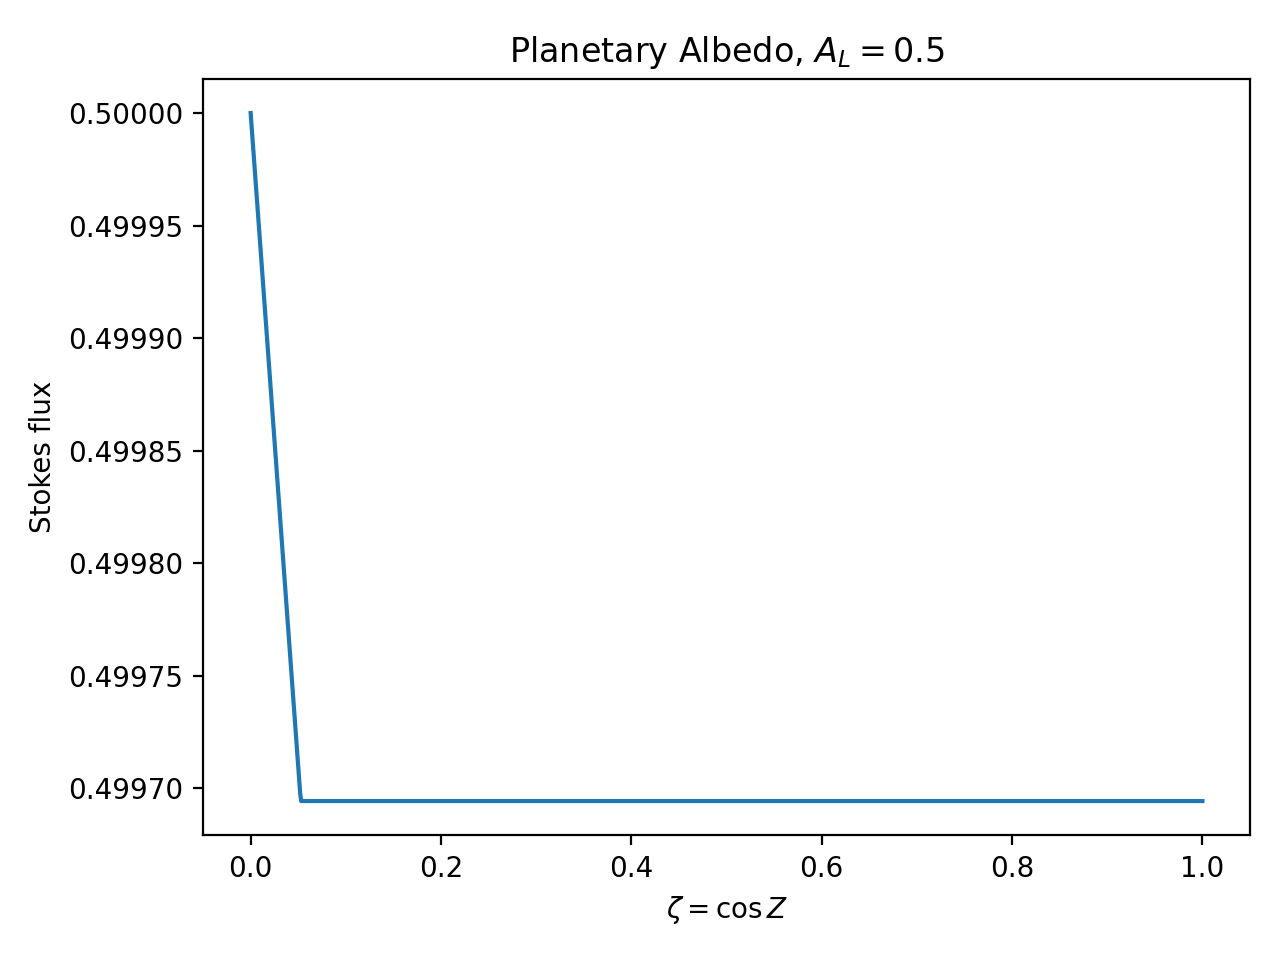

.
----------------------------------------------------------------------
Ran 1 test in 0.075s

OK


In [141]:
#@test:template
def test_graysurface(self):
    
    Verbose.VERBOSITY=VERB_ALL
    
    Scatterer.reset_catalogue()
    
    G=GraySurface(AL=0.5)
    etas=np.linspace(0,1,1000)
    print(G.calculate_stokes(etas[100],0,0,0,0,0))

    fig,axs=plt.subplots(1,1)
    ax=axs
    ax.plot(etas,G.calculate_stokes(etas,0,0,0,0,0)[:,0])
    ax.set_xlabel(r"$\zeta = \cos Z$")
    ax.set_ylabel(r"Stokes flux")
    ax.set_title(rf"Planetary Albedo, $A_L=${G.AL}");

    fig.tight_layout()
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_graysurface=test_graysurface
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Gray atmosphere

In [142]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class GrayAtmosphere
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class GrayAtmosphere(Scatterer):
    """Gray Atmopshere.
    
    This is the scatterer corresponding to plane-parallel analytical gray atmosphere
    """
    
    def __init__(self,**params):

        if self.register(self,params):        
            verbose(VERB_SIMPLE,f"Initializing {self.params['name']} with hash {self.hash}")
            
            #Gray albedo
            self.AS=params["AS"]

            #Load reflection functions
            self._load_reflection_functions()

            #Calculate the gammap parameter
            self.gamma0=self._find_gamma()

            #Accelerate the calculation of the albedo
            self._accelerate_lambertian_albedo()

    def calculate_stokes(self,eta,zeta,delta,beta,wavelen,
                         reflection=True,**params):
        size = self.check_size(eta)
        f = np.zeros((size,4))
        albedo = self._get_albedo(eta)
        f[:,0] = albedo
        return f
        
    #####################################
    #Complimentary routines
    #####################################
    def _load_reflection_functions(self):
        """Load value of reflection fucntions.

        Update:
            fint: 2d interpolating function:
                x: eta (cosine incident angle)
                y: zeta (cosine scattering angle)

        Notes:
            Tab. (2.3) in Sobolev (1975).
        """
        data_ss=np.loadtxt(Misc.get_data("diffuse_reflection_function.data"))
        eta=data_ss[1:,0]
        gamma=data_ss[0,1:]
        f=data_ss[1:,1:]
        self.fint=interp2d(gamma,eta,f)  

    def _calc_reflection_coefficient(self,eta,zeta,gamma0=1):
        """Reflection coefficient of a semi-infinite (tau = infinity) atmosphere with (gray) 
        single scattering albedo gamma0

        Requires:
            - _loadReflectionFunctions

        Notes:
            Ec. (2.43) in Sobolev (1975).
        """
        rho0=gamma0*self.fint(gamma0,eta)[0]*self.fint(gamma0,zeta)[0]/(4*(eta+zeta))
        return rho0

    def _calc_spherical_albedo(self,gamma0):
        """
        Compute spherical albedo from single scattering albedo for a semi-infinite atmosphere.

        Parameters:
            gamma0: single scattering albedo (0<=gamma0<=1), float.

        Returns:
            AS: ratio of the energy diffusely reflected by a spherical planet (0<=AS<=1), float.

        Requires:
            - _loadReflectionFunctions

        Notes:
            Ec. (1.87) in Sobolev (1975).    
        """

        AS=4*dblquad(lambda y,x,*args:self._calc_reflection_coefficient(x,y,*args)*x*y,
                     0,1,lambda x:0,lambda x:1,epsrel=1e-2,args=(gamma0,))[0]
        return AS

    def _find_gamma(self):
        """
        Starting with a target spherical albedo AS, find the value of the single scattering albedo gamma0
        of a semi-infinite atmosphere having that Albedo.

        Returns:
            gamma0: the value of gamma0 corresponding to AS (0<=gamma0<=1), float.
        """
        if np.isclose(self.AS,1,rtol=1e-2):
            return 1
        function=lambda gamma0:self._calc_spherical_albedo(gamma0)-self.AS
        gamma0=bisect(function,0.0,1.0,rtol=1e-4)
        return gamma0 if gamma0<=1 else 1

    def _calc_lambertian_albedo(self,eta):
        """
        Notes: 
            Yanovistkii (1973)
        """
        integrand=lambda zeta:self._calc_reflection_coefficient(eta,zeta,gamma0=self.gamma0)*zeta
        AL=2*quad(integrand,0,1,epsrel=1e-3)[0]
        return AL

    def _accelerate_lambertian_albedo(self):
        etas=np.linspace(0,1,20)
        ALs=np.array([self._calc_lambertian_albedo(eta) for eta in etas])
        self._get_albedo=interp1d(etas,ALs)


And test it:

  VERB1::reset_catalogue:: Resetting Scatterers catalogue
  VERB1::register:: Scatterer with name GrayAtmosphere and hash 4987696056294493218 already exist at 140570422827968
[[0.31503104 0.         0.         0.        ]]


<IPython.core.display.Javascript object>


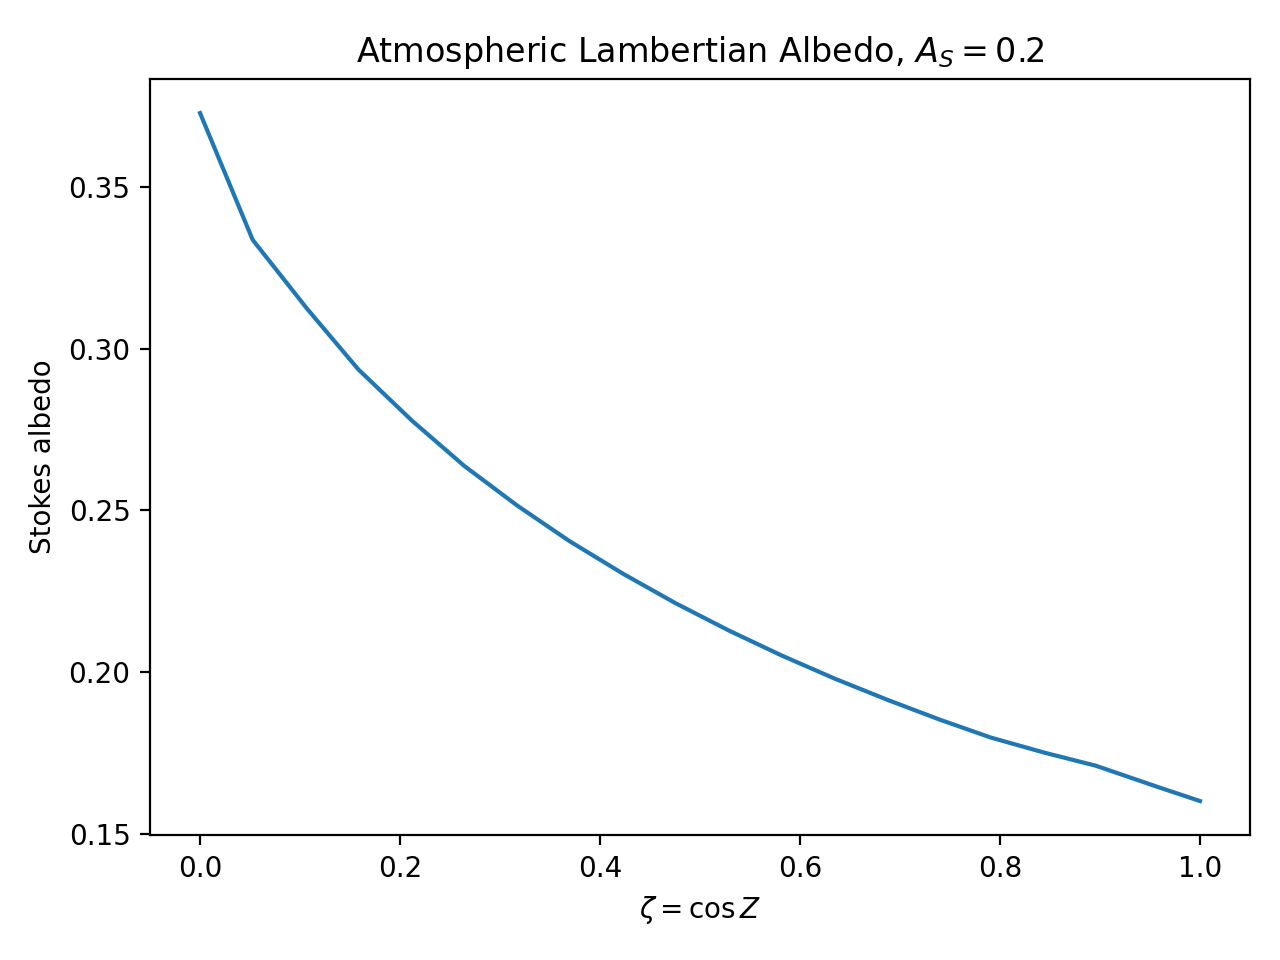

.
----------------------------------------------------------------------
Ran 1 test in 0.078s

OK


In [144]:
#@test:template
def test_lambatmos(self):
    
    Verbose.VERBOSITY=VERB_ALL
    
    Scatterer.reset_catalogue()

    GA=GrayAtmosphere(AS=0.2)
    etas=np.linspace(0,1,1000)
    
    print(GA.calculate_stokes(etas[100],0,0,0,0,0))

    fig,axs=plt.subplots(1,1)
    ax=axs
    ax.plot(etas,GA.calculate_stokes(etas,0,0,0,0,0)[:,0])
    ax.set_xlabel(r"$\zeta = \cos Z$")
    ax.set_ylabel(r"Stokes albedo")
    ax.set_title(rf"Atmospheric Lambertian Albedo, $A_S=${GA.AS}");

    fig.tight_layout()
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_lambatmos=test_lambatmos
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Fourier scatterers

In [149]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class FourierCoefficients
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class FourierCoefficients(ctypes.Structure):
    """Fourier coefficients ctypes structure
    """
    _fields_=[
        ("nmat",ctypes.c_int),
        ("nmugs",ctypes.c_int),
        ("nfou",ctypes.c_int),
        ("xmu",PDOUBLE),
        ("rfou",PPPDOUBLE),
        ("rtra",PPPDOUBLE),
    ]
    def __init__(self,nmat,nmugs,nfou,xmu,rfou,rtra):
        self.nmat=nmat
        self.nmugs=nmugs
        self.nfou=nfou
        self.xmu=ExtensionUtil.vec2ptr(xmu)
        self.rfou=ExtensionUtil.cub2ptr(rfou)
        self.rtra=ExtensionUtil.cub2ptr(rtra)

In [203]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Class StokesScatterer
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class FourierScatterer(Scatterer):
    """Scatterer defined in terms of a Fourier expansion of the transmission 
    and reflection matrices.
    """
    def __init__(self,**params):

        if self.register(self,params):        
            verbose(VERB_SIMPLE,f"Initializing {self.params['name']} with hash {self.hash}")
            
            #Gray albedo
            self.foufile=params["foufile"]

            if not os.path.isfile(self.foufile):
                raise AssertionError(f"Fourier coefficients file '{self.foufile}' does not exist")
            
            #Load reflection functions
            self._read_foufile(self.foufile)

    def calculate_stokes(self,eta,zeta,delta,beta,wavelen,
                         reflection=True,**params):
        npix=self.check_size(eta)
        apix=np.array([1.0]*npix)
        
        #Return arrays
        Sarr=np.zeros((npix,self.F.nmat+1))
        Sarr_ptr=ExtensionUtil.mat2ptr(Sarr)
        
        #Call routine
        cpixx_ext.reflection(self.F,int(reflection),npix,
                             ExtensionUtil.vec2ptr(delta),
                             ExtensionUtil.vec2ptr(beta),
                             ExtensionUtil.vec2ptr(eta),
                             ExtensionUtil.vec2ptr(zeta),
                             ExtensionUtil.vec2ptr(apix),
                             Sarr_ptr);
        
        #Extract stokes vector
        stokes=ExtensionUtil.ptr2mat(Sarr_ptr,*Sarr.shape)
        return stokes
    
    def _read_foufile(self,filename):
        """
        Read a file containing fourier coefficients produced by PyMieDAP

        Parameters:

           filename: string:

        Returns:

            nmugs: int:
               Number of gaussian integration coefficients.

            nmat: int:
               Number of matrix.

            nfou: int:
               Number of coefficients.

            rfout: array (nmugs*nmat,nmugs,nfou):
               Matrix for the fourier coefficients for reflection.

            rtra: array (nmugs*nmat,nmugs,nfou): 
               Matrix for the fourier coefficients for transmission
        """
        f=open(filename)

        #Read header
        nmat=0
        imu=0
        for i,line in enumerate(f):
            if '#' in line:
                continue
            data=line.split()
            if len(data)<3:
                if len(data)==1:
                    if not nmat:
                        nmat=int(data[0])
                    else:
                        nmugs=int(data[0])
                        xmu=np.zeros(nmugs)
                else:
                    xmu[imu]=float(data[0])
                    imu+=1
            else:
                break

        #Get core data
        data=np.loadtxt(filename,skiprows=i)
        nfou=int(data[:,0].max())+1

        rfou=np.zeros((nmat*nmugs,nmugs,nfou))
        rtra=np.zeros((nmat*nmugs,nmugs,nfou))

        #Read fourier coefficients
        for row in data:
            m,i,j=int(row[0]),int(row[1])-1,int(row[2])-1
            ibase=i*nmat
            rfou[ibase:ibase+3,j,m]=row[3:3+nmat]
            if len(row[3:])>nmat:
                rtra[ibase:ibase+3,j,m]=row[3+nmat:3+2*nmat]

        verbose(VERB_SIMPLE,f"Checksum '{filename}': {rfou.sum()+rtra.sum():.16e}")
        f.close()
        
        self.nmat,self.nmugs,self.nfou=nmat,nmugs,nfou
        self.xmu,self.rfou,self.rtra=xmu,rfou,rtra
        self.F=FourierCoefficients(nmat,nmugs,nfou,xmu,rfou,rtra)

In [226]:
SCATTERERS_CATALOGUE=dict()
#F=FourierScatterer(foufile=Misc.get_data("fou_gasplanet.dat"))

In [227]:
foufile = "../../doc/papers/full-scattering/tmp/fou_ring_1_0_0_8.dat"
F=FourierScatterer(foufile=foufile)
SCr=StokesScatterer(foufile)

In [210]:
teta0s = np.array([0.0])
tetas = np.array([0.0])
etas = np.cos(teta0s)
zetas = np.cos(tetas)
deltas = np.array([0.0*Consts.deg])
betas = np.array([0.0])
wavelen = 0 
reflection = 1
F.calculate_stokes(etas,zetas,deltas,betas,wavelen,reflection)

array([[0.05351844, 0.        , 0.        , 0.        ]])

In [211]:
afs=np.array([1.0])
SCr.calculate_stokes(deltas,betas,etas,zetas,afs,reflection)

array([[0.05351844, 0.        , 0.        , 0.        ]])

In [223]:
etas=np.linspace(0,1,10)
zetas=np.linspace(0,1,10)
deltas=np.linspace(0,360,10)*Consts.deg
betas=np.linspace(0,180,10)*Consts.deg
wavelen = 0 
reflection = 0
f=F.calculate_stokes(etas,zetas,deltas,betas,wavelen,reflection)

In [224]:
afs=np.array([1.0]*len(etas))
fs=SCr.calculate_stokes(deltas,betas,etas,zetas,afs,reflection)

In [225]:
(f-fs).max()

0.0

In [8]:
#@test:template
def test_catalogue(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_NONE
    
    for key,item in SCATTERERS_CATALOGUE.items():
        print(f"{key}: {item}")

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_catalogue=test_catalogue
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

12010540114555749990: {'params': {'A': 1, 'name': 'MySurface', 'hash': '12010540114555749990'}, 'hash': '12010540114555749990', 'A': 1, 'AA': 1}
13240899717716971543: {'params': {'name': 'NeutralSurface', 'hash': '13240899717716971543'}, 'hash': '13240899717716971543'}
187880162924494581: {'params': {'name': 'BlackBodySurface', 'hash': '187880162924494581'}, 'hash': '187880162924494581'}
8691060526272545200: {'params': {'AL': 0.5, 'name': 'LambertianGraySurface', 'hash': '8691060526272545200'}, 'hash': '8691060526272545200', 'phase_law': <function LambertianGraySurface.__init__.<locals>.<lambda> at 0x7fd5eab290d0>, 'AL': 0.5, 'gammap0': 0.07952880859375}
17952562352456873716: {'params': {'AS': 0.5, 'name': 'LambertianGrayAtmosphere', 'hash': '17952562352456873716'}, 'hash': '17952562352456873716', 'AS': 0.5, 'fint': <scipy.interpolate.interpolate.interp2d object at 0x7fd60916ba30>, 'gamma0': 0.91009521484375}



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [10]:
#@test:template
def test_upscat(self):
    
    global sys
    
    Verbose.VERBOSITY=VERB_NONE
    
    nspangles=50
    sys=System()
    S=sys.add(kind="Star",nspangles=nspangles,
              radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
    P=sys.add(kind="Planet",parent=S,nspangles=nspangles,
              a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul,spangle_type=SPANGLE_ATMOSPHERIC)
    R=sys.add(kind="Ring",parent=P,nspangles=nspangles,
              fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)
    
    
    #Prepare system
    sys.initialize_simulation()
    sys.spangle_system()    
    sys.update_scatterers()
    
    #Show scatterers
    for key,item in SCATTERERS_CATALOGUE.items():
        print(f"{key}: {item.params['name']}")
        
    #Show scatterers
    print(sys.data.scatterer.unique())
    print(sys.spangle_scatterers)
    
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_upscat=test_upscat
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

12010540114555749990: MySurface
13240899717716971543: NeutralSurface
187880162924494581: BlackBodySurface
8691060526272545200: LambertianGraySurface
17952562352456873716: LambertianGrayAtmosphere
17092448437039068465: LambertianGrayAtmosphere
5668689812315627122: LambertianGraySurface
['187880162924494581' '17092448437039068465' '5668689812315627122']
{2: (<class 'pryngles.scatterer.LambertianGrayAtmosphere'>, {'AS': 'albedo_gray_spherical'}), 4: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 3: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 1: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 0: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 5: (<class 'pryngles.scatterer.BlackBodySurface'>, {}), 6: (<class 'pryngles.scatterer.BlackBodySurface'>, {})}



----------------------------------------------------------------------
Ran 1 test in 1.043s

OK


### The end

In [67]:
#@end:module